<a href="https://colab.research.google.com/github/TrinhNhatHuy/Deep-learning---egg-detection/blob/main/Egg_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Egg_Dataset/egg.zip'
extract_path = '/content/'

# Unzip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully!


Dataset Statistics:
Damaged eggs: 632
Not Damaged eggs: 162
Total images: 794
Class ratio: 3.9


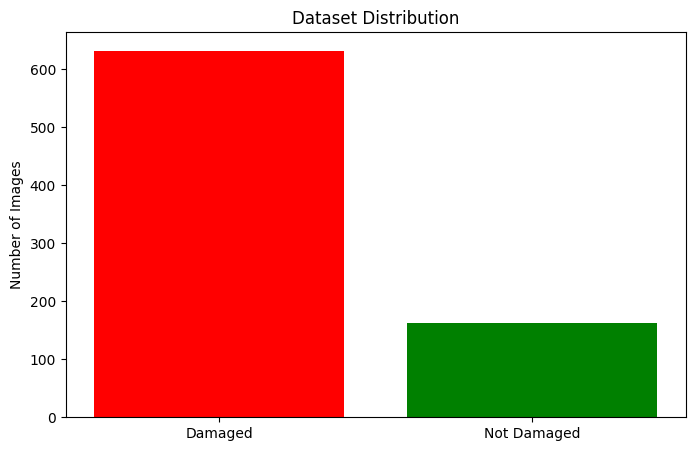

Data exploration done


In [4]:
# 1 DATA EXPLORATION AND VISUALIZATION

import matplotlib.pyplot as plt
import os

dataset_path = '/content/Eggs Classification'

damaged_path = os.path.join(dataset_path, 'Damaged')
not_damaged_path = os.path.join(dataset_path, 'Not Damaged')

num_damaged = len([f for f in os.listdir(damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
num_not_damaged = len([f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
total_images = num_damaged + num_not_damaged

print("Dataset Statistics:")
print("Damaged eggs:", num_damaged)
print("Not Damaged eggs:", num_not_damaged)
print("Total images:", total_images)
print("Class ratio:", round(num_damaged/num_not_damaged, 2))

plt.figure(figsize=(8, 5))
plt.bar(['Damaged', 'Not Damaged'], [num_damaged, num_not_damaged], color=['red', 'green'])
plt.title('Dataset Distribution')
plt.ylabel('Number of Images')
plt.show()

print("Data exploration done")

Configuration:
Image size: (150, 150)
Batch size: 16
Cleaning up old augmented data...
Removed 0 old augmented images
Counting original images...
Original Damaged images: 632
Original Not Damaged images: 162
Total images: 794
Target Not Damaged images: 600
Additional images needed: 438
Found 162 original images to augment
Conservative augmentation configured
Saving augmented images to: /content/Eggs Classification/Not Damaged
Generating approximately 3 augmented images per original image
Generated 50 / 438 augmented images
Generated 100 / 438 augmented images
Generated 150 / 438 augmented images
Generated 200 / 438 augmented images
Generated 250 / 438 augmented images
Generated 300 / 438 augmented images
Generated 350 / 438 augmented images
Generated 400 / 438 augmented images
Successfully generated 438 augmented images
Updated Dataset Statistics:
Damaged eggs: 632
Not Damaged eggs: 600 (was 162 )
Total images: 1232
Class ratio: 1.05


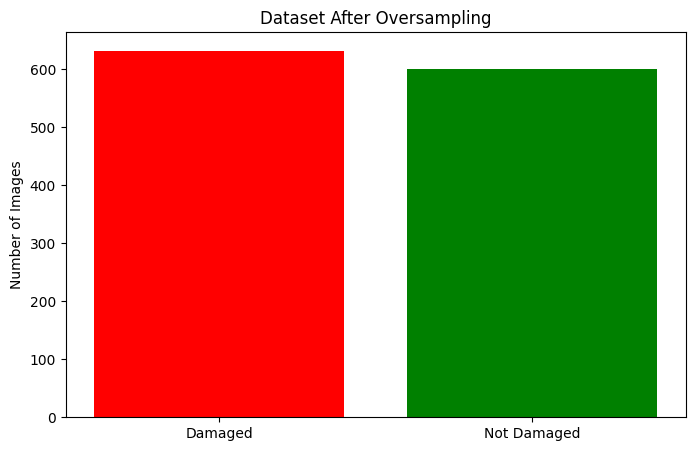

Calculating class weights...
Class Weights:
Damaged (class 0): 0.975
Not Damaged (class 1): 1.027
Setting up data augmentation for training...
Found 986 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Data Generators Created:
Training samples: 986
Validation samples: 246
Class indices: {'Damaged': 0, 'Not Damaged': 1}
Steps per epoch: 61


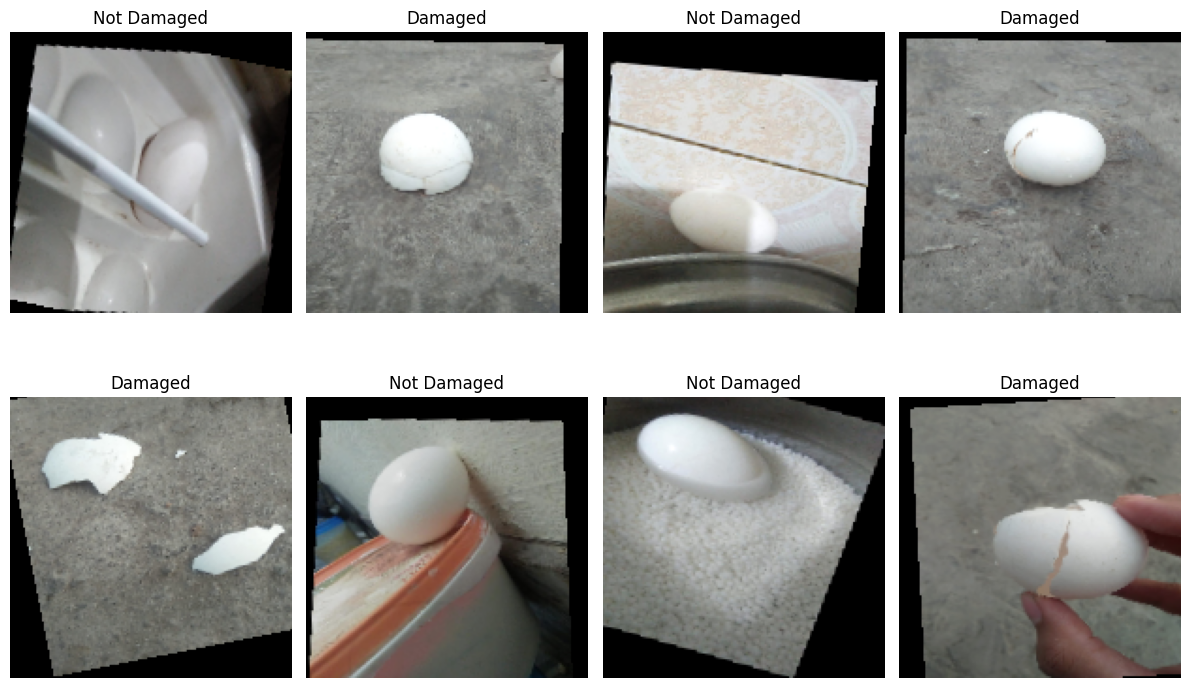

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from PIL import Image

dataset_path = '/content/Eggs Classification'

img_size = (150, 150)
batch_size = 16

print("Configuration:")
print("Image size:", img_size)
print("Batch size:", batch_size)

print("Cleaning up old augmented data...")
damaged_path = os.path.join(dataset_path, 'Damaged')
not_damaged_path = os.path.join(dataset_path, 'Not Damaged')

# Remove old augmented images
augmented_files = [f for f in os.listdir(not_damaged_path) if f.startswith(('aug_', 'conservative_aug_'))]
for file in augmented_files:
    file_path = os.path.join(not_damaged_path, file)
    os.remove(file_path)

print("Removed", len(augmented_files), "old augmented images")

# Count original images
print("Counting original images...")
num_damaged = len([f for f in os.listdir(damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
num_not_damaged = len([f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
total_images = num_damaged + num_not_damaged

print("Original Damaged images:", num_damaged)
print("Original Not Damaged images:", num_not_damaged)
print("Total images:", total_images)

# Calculate how many additional images needed
target_not_damaged = 600
additional_needed = target_not_damaged - num_not_damaged

print("Target Not Damaged images:", target_not_damaged)
print("Additional images needed:", additional_needed)

if additional_needed > 0:
    not_damaged_images = [f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print("Found", len(not_damaged_images), "original images to augment")

    # Create conservative augmentation
    conservative_augmentation_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.9, 1.1],
        fill_mode='constant',
    )

    print("Conservative augmentation configured")
    augmented_dir = not_damaged_path
    print("Saving augmented images to:", augmented_dir)

    augmented_count = 0
    images_per_original = max(1, additional_needed // len(not_damaged_images) + 1)
    print("Generating approximately", images_per_original, "augmented images per original image")

    for img_file in not_damaged_images:
        if augmented_count >= additional_needed:
            break

        try:
            img_path = os.path.join(not_damaged_path, img_file)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            aug_iter = conservative_augmentation_datagen.flow(
                img_array,
                batch_size=1,
                save_to_dir=augmented_dir,
                save_prefix=f'conservative_aug_{augmented_count:04d}',
                save_format='jpg',
                seed=42 + augmented_count
            )

            for i in range(images_per_original):
                if augmented_count >= additional_needed:
                    break

                next(aug_iter)
                augmented_count += 1

                if augmented_count % 50 == 0:
                    print("Generated", augmented_count, "/", additional_needed, "augmented images")

        except Exception as e:
            print("Warning: Could not process", img_file, ":", e)
            continue

    print("Successfully generated", augmented_count, "augmented images")

    # Update counts
    num_not_damaged_updated = len([f for f in os.listdir(not_damaged_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    total_images_updated = num_damaged + num_not_damaged_updated

    print("Updated Dataset Statistics:")
    print("Damaged eggs:", num_damaged)
    print("Not Damaged eggs:", num_not_damaged_updated, "(was", num_not_damaged, ")")
    print("Total images:", total_images_updated)
    print("Class ratio:", round(num_damaged/num_not_damaged_updated, 2))

    num_not_damaged = num_not_damaged_updated
    total_images = total_images_updated

    # Visualize updated distribution
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Damaged', 'Not Damaged'], [num_damaged, num_not_damaged], color=['red', 'green'])
    plt.title('Dataset After Oversampling')
    plt.ylabel('Number of Images')
    plt.show()

else:
    print("No oversampling needed")

# Calculate class weights
print("Calculating class weights...")
try:
    class_weights = compute_class_weight(
        'balanced',
        classes=np.array([0, 1]),
        y=np.concatenate([np.zeros(num_damaged), np.ones(num_not_damaged)])
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:")
    print("Damaged (class 0):", round(class_weight_dict[0], 3))
    print("Not Damaged (class 1):", round(class_weight_dict[1], 3))

except Exception as e:
    print("Error calculating class weights:", e)
    class_weight_dict = None

# Create training generator with augmentation
print("Setting up data augmentation for training...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    validation_split=0.2
)

# Create validation generator without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# Create validation generator
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

print("Data Generators Created:")
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)
print("Class indices:", train_generator.class_indices)
print("Steps per epoch:", train_generator.samples // batch_size)

# Visualize sample images
class_names = list(train_generator.class_indices.keys())
images_batch, labels_batch = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(min(8, len(images_batch))):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images_batch[i])
    plt.title(class_names[int(labels_batch[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# 3 MOBILENETV2 MODEL ARCHITECTURE

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Clear any previous models
tf.keras.backend.clear_session()

# Build MobileNetV2 base
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False  # Freeze for Phase 1

# Optimized classifier for MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(" MobileNetV2 Model Built!")
model.summary()

print(f"\n📊 MobileNetV2 Model Info:")
print(f"   Total layers: {len(model.layers)}")
print(f"   Input shape: {model.input_shape}")
print(f"   Output shape: {model.output_shape}")
print(f"   Trainable params: {model.count_params():,}")

/tmp/ipython-input-2760577448.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
 MobileNetV2 Model Built!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


📊 MobileNetV2 Model Info:
   Total layers: 6
   Input shape: (None, 150, 150, 3)
   Output shape: (None, 1)
   Trainable params: 2,422,081


In [7]:
# 4 TRAINING CALLBACKS FOR MOBILENETV2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Optimized callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    '/content/best_mobilenet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print(" MobileNetV2 Callbacks configured:")
print("   - Early Stopping (patience: 12)")
print("   - Learning Rate Reduction (patience: 6)")
print("   - Model Checkpointing")
print("   - File: /content/best_mobilenet_model.keras")

 MobileNetV2 Callbacks configured:
   - Early Stopping (patience: 12)
   - Learning Rate Reduction (patience: 6)
   - Model Checkpointing
   - File: /content/best_mobilenet_model.keras


In [11]:
# PHASE 1 - CLASSIFIER HEAD TRAINING

from tensorflow.keras.optimizers import Adam

# Check data pipeline
sample_images, sample_labels = next(train_generator)
positive_count = np.sum(sample_labels)
negative_count = len(sample_labels) - positive_count
balance_ratio = positive_count / len(sample_labels)

print("Batch Balance Check:")
print("Positive:", positive_count, "Negative:", negative_count)
print("Balance ratio:", round(balance_ratio, 2))

# FIX: Convert class weights to regular Python floats
class_weight_dict_fixed = {0: float(class_weight_dict[0]), 1: float(class_weight_dict[1])}

print("Training Configuration:")
print("Batch size:", train_generator.batch_size)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)
print("Class weights:", class_weight_dict_fixed)  # Use fixed version

def train_classifier_head(model, train_gen, val_gen, class_weights, epochs=15):
    print("PHASE 1: Training Classifier Head")
    print("Base model: FROZEN | Learning rate: 0.0001")

    # Freeze base model
    base_model.trainable = False
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Callbacks
    callbacks_phase1 = [
        EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.00001),
        ModelCheckpoint('/content/mobilenet_phase1.keras', monitor='val_accuracy', save_best_only=True)
    ]

    print("Starting Phase 1 training...")
    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        class_weight=class_weights,  # This will handle the imbalance!
        callbacks=callbacks_phase1,
        verbose=1
    )

    final_acc = history.history['val_accuracy'][-1]
    best_acc = max(history.history['val_accuracy'])
    print("Phase 1 completed -", len(history.history['loss']), "epochs trained")
    print("Final val_accuracy:", round(final_acc, 4), "Best:", round(best_acc, 4))
    return history

print("STARTING PHASE 1 TRAINING...")
print("Note: Batch imbalance is normal. Class weights will handle it during training.")

try:
    # Phase 1 training - USE THE FIXED CLASS WEIGHTS
    history1 = train_classifier_head(
        model=model,
        train_gen=train_generator,
        val_gen=validation_generator,
        class_weights=class_weight_dict_fixed,  # Use the fixed version
        epochs=15
    )

    # Save results
    phase1_best_accuracy = max(history1.history['val_accuracy'])
    phase1_final_accuracy = history1.history['val_accuracy'][-1]
    phase1_epochs_trained = len(history1.history['loss'])

    print("PHASE 1 COMPLETED - Best accuracy:", round(phase1_best_accuracy, 4))
    print("Proceed to evaluation and Phase 2")

except Exception as e:
    print("Phase 1 training failed:", e)
    print("Try reducing batch size or learning rate")

Batch Balance Check:
Positive: 9.0 Negative: 7.0
Balance ratio: 0.56
Training Configuration:
Batch size: 16
Steps per epoch: 61
Validation steps: 15
Class weights: {0: 0.9746835443037974, 1: 1.0266666666666666}
STARTING PHASE 1 TRAINING...
Note: Batch imbalance is normal. Class weights will handle it during training.
PHASE 1: Training Classifier Head
Base model: FROZEN | Learning rate: 0.0001
Starting Phase 1 training...
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - accuracy: 0.7749 - loss: 0.4847 - precision: 0.7735 - recall: 0.7707 - val_accuracy: 0.8417 - val_loss: 0.3647 - val_precision: 0.7794 - val_recall: 0.9298 - learning_rate: 1.0000e-04
Epoch 2/15
 1/61 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6875 - loss: 0.4200 - precision: 0.8000 - recall: 0.7273

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6875 - loss: 0.4200 - precision: 0.8000 - recall: 0.7273 - val_accuracy: 0.8458 - val_loss: 0.3676 - val_precision: 0.7770 - val_recall: 0.9474 - learning_rate: 1.0000e-04
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.8361 - loss: 0.3692 - precision: 0.7996 - recall: 0.8697 - val_accuracy: 0.8583 - val_loss: 0.3204 - val_precision: 0.8390 - val_recall: 0.8684 - learning_rate: 1.0000e-04
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8000 - loss: 0.3449 - precision: 0.8333 - recall: 0.8333 - val_accuracy: 0.8583 - val_loss: 0.3179 - val_precision: 0.8333 - val_recall: 0.8772 - learning_rate: 1.0000e-04
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.8570 - loss: 0.3202 - precision: 0.8498 - recall: 0.8611 - val_accuracy: 0.8917 - val_loss: 0.2793 - val_precision: 0.8188 - val_recall: 0.9912 - learning_rate: 1.0000e-04
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accura

PHASE 1 EVALUATION & PHASE 2 STRATEGY
Phase 1 results loaded - Best accuracy: 0.9333


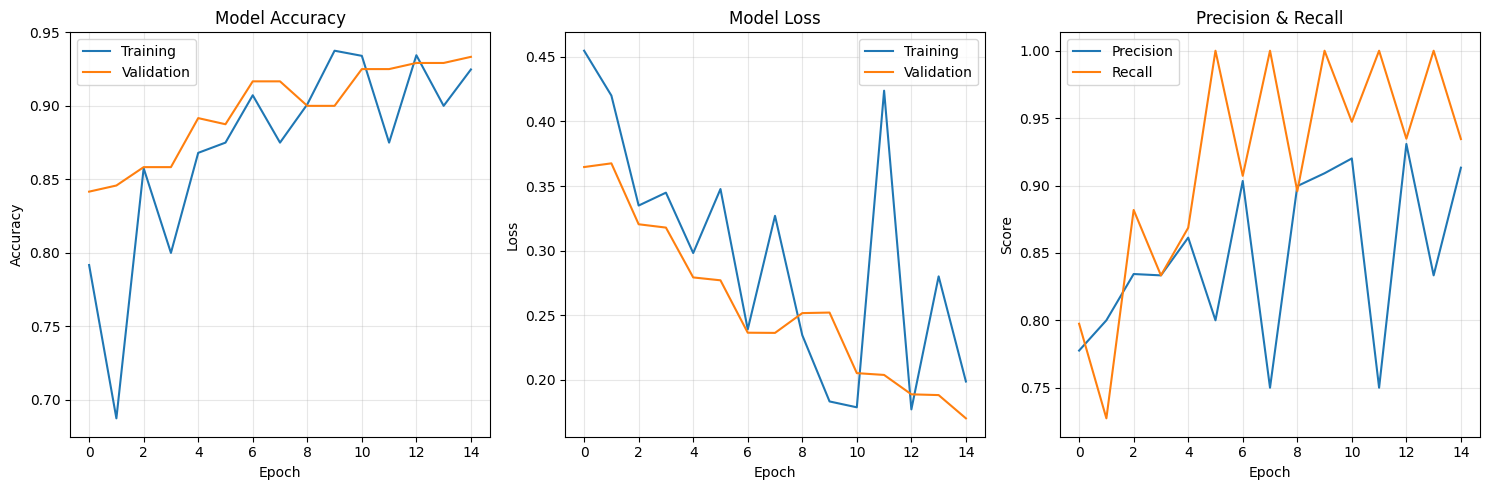

Performance Analysis:
Final Training Accuracy: 0.9247
Final Validation Accuracy: 0.9333
Accuracy Gap: -0.0086
Overfitting: Low - good generalization
PHASE 2 STRATEGY:
Excellent performance - Use conservative approach
Unfreeze layers: 20-30
Learning rate: 0.000005
Epochs: 10-15
Ready for Phase 2!


In [12]:
# PHASE 1 EVALUATION & PHASE 2 PLANNING

import matplotlib.pyplot as plt
import numpy as np

print("PHASE 1 EVALUATION & PHASE 2 STRATEGY")

# Check Phase 1 results
try:
    history1
    phase1_best_accuracy = max(history1.history['val_accuracy'])
    print("Phase 1 results loaded - Best accuracy:", round(phase1_best_accuracy, 4))
except NameError:
    print("No Phase 1 history found. Run previous cell first.")
    raise

# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 3, 2)
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall
plt.subplot(1, 3, 3)
if 'precision' in history1.history and 'recall' in history1.history:
    plt.plot(history1.history['precision'], label='Precision')
    plt.plot(history1.history['recall'], label='Recall')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance analysis
final_train_acc = history1.history['accuracy'][-1]
final_val_acc = history1.history['val_accuracy'][-1]
accuracy_gap = final_train_acc - final_val_acc

print("Performance Analysis:")
print("Final Training Accuracy:", round(final_train_acc, 4))
print("Final Validation Accuracy:", round(final_val_acc, 4))
print("Accuracy Gap:", round(accuracy_gap, 4))

if accuracy_gap > 0.1:
    print("Overfitting: High - need more regularization")
elif accuracy_gap > 0.05:
    print("Overfitting: Moderate - monitor closely")
else:
    print("Overfitting: Low - good generalization")

# Phase 2 strategy
print("PHASE 2 STRATEGY:")

if phase1_best_accuracy >= 0.92:
    print("Excellent performance - Use conservative approach")
    print("Unfreeze layers: 20-30")
    print("Learning rate: 0.000005")
    print("Epochs: 10-15")
    recommended_unfreeze = 30
    recommended_lr = 0.000005
    recommended_epochs = 15
else:
    print("Good performance - Use standard approach")
    print("Unfreeze layers: 40-50")
    print("Learning rate: 0.00001")
    print("Epochs: 15-20")
    recommended_unfreeze = 50
    recommended_lr = 0.00001
    recommended_epochs = 20

print("Ready for Phase 2!")

PHASE 1 PERFORMANCE SUMMARY:
Validation Accuracy: 0.9333
Accuracy Gap: -0.0107 (Excellent generalization)
Overfitting Risk: LOW
STARTING CONSERVATIVE FINE-TUNING...
CONSERVATIVE FINE-TUNING STRATEGY
Unfreezing last 30 layers
Learning rate: 5e-06
Epochs: 15
Layer unfreezing summary:
Total layers: 154
Frozen layers: 124
Unfrozen layers: 30
Starting conservative fine-tuning...
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.7845 - loss: 0.4303 - precision: 0.9537 - recall: 0.5696 - val_accuracy: 0.9333 - val_loss: 0.1754 - val_precision: 0.8889 - val_recall: 0.9825 - learning_rate: 5.0000e-06
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8125 - loss: 0.4187 - precision: 1.0000 - recall: 0.7000 - val_accuracy: 0.9333 - val_loss: 0.1755 - val_precision: 0.8889 - val_recall: 0.9825 - learning_rate: 5.0000e-06
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.8673 - loss: 0.3200 - precision: 0.9309 - recall: 0.7855 - val_accuracy: 0.9208 

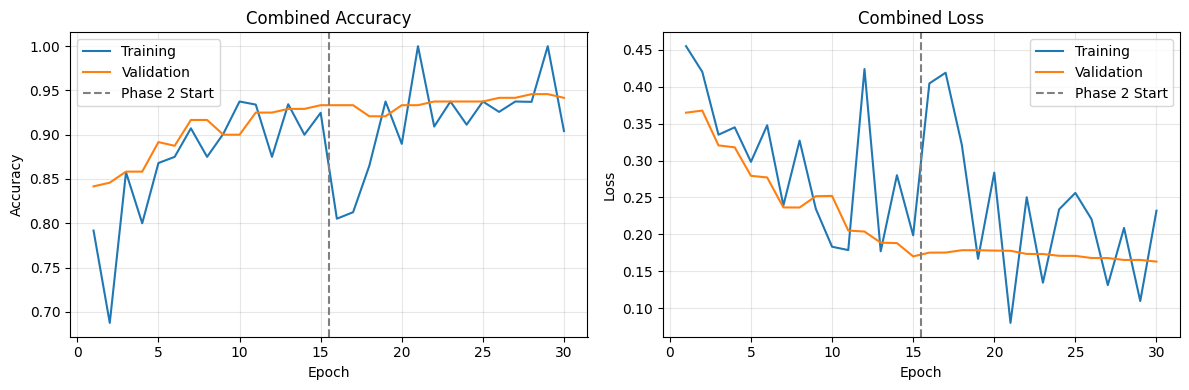

NEXT STEPS: Model >94% - Ready for deployment!
Training completed!


In [13]:
# PHASE 2 - CONSERVATIVE FINE-TUNING

print("PHASE 1 PERFORMANCE SUMMARY:")
print("Validation Accuracy: 0.9333")
print("Accuracy Gap: -0.0107 (Excellent generalization)")
print("Overfitting Risk: LOW")

def conservative_fine_tune_model(model, train_gen, val_gen, class_weights, unfreeze_layers=30, epochs=15, learning_rate=0.000005):
    print("CONSERVATIVE FINE-TUNING STRATEGY")
    print("Unfreezing last", unfreeze_layers, "layers")
    print("Learning rate:", learning_rate)
    print("Epochs:", epochs)

    # Unfreeze last few layers
    base_model.trainable = True
    layers_unfrozen = 0
    layers_frozen = 0

    for i, layer in enumerate(base_model.layers):
        if i >= len(base_model.layers) - unfreeze_layers:
            layer.trainable = True
            layers_unfrozen += 1
        else:
            layer.trainable = False
            layers_frozen += 1

    print("Layer unfreezing summary:")
    print("Total layers:", len(base_model.layers))
    print("Frozen layers:", layers_frozen)
    print("Unfrozen layers:", layers_unfrozen)

    # Recompile with low learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Callbacks
    callbacks_phase2 = [
        EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001),
        ModelCheckpoint('/content/mobilenet_final_conservative.keras', monitor='val_accuracy', save_best_only=True)
    ]

    print("Starting conservative fine-tuning...")
    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )

    return history

def analyze_phase2_improvement(history1, history2):
    phase1_best = max(history1.history['val_accuracy'])
    phase2_best = max(history2.history['val_accuracy'])
    improvement = phase2_best - phase1_best

    print("PHASE 2 IMPROVEMENT ANALYSIS:")
    print("Phase 1 Best:", round(phase1_best, 4))
    print("Phase 2 Best:", round(phase2_best, 4))
    print("Improvement:", round(improvement, 4))

    if improvement > 0.015:
        return "EXCELLENT - Significant improvement"
    elif improvement > 0.005:
        return "GOOD - Meaningful improvement"
    elif improvement > 0:
        return "MODEST - Small improvement"
    else:
        return "STABLE - Maintained performance"

def plot_combined_training(history1, history2):
    import matplotlib.pyplot as plt

    total_epochs = len(history1.history['loss']) + len(history2.history['loss'])
    phase_split = len(history1.history['loss'])

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, total_epochs + 1),
             history1.history['accuracy'] + history2.history['accuracy'],
             label='Training')
    plt.plot(range(1, total_epochs + 1),
             history1.history['val_accuracy'] + history2.history['val_accuracy'],
             label='Validation')
    plt.axvline(x=phase_split + 0.5, color='gray', linestyle='--', label='Phase 2 Start')
    plt.title('Combined Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, total_epochs + 1),
             history1.history['loss'] + history2.history['loss'],
             label='Training')
    plt.plot(range(1, total_epochs + 1),
             history1.history['val_loss'] + history2.history['val_loss'],
             label='Validation')
    plt.axvline(x=phase_split + 0.5, color='gray', linestyle='--', label='Phase 2 Start')
    plt.title('Combined Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Execute fine-tuning
print("STARTING CONSERVATIVE FINE-TUNING...")

try:
    history2 = conservative_fine_tune_model(
        model=model,
        train_gen=train_generator,
        val_gen=validation_generator,
        class_weights=class_weight_dict,
        unfreeze_layers=30,
        epochs=15,
        learning_rate=0.000005
    )

    improvement_verdict = analyze_phase2_improvement(history1, history2)

    print("FINAL TRAINING SUMMARY")
    print("Phase 1:", len(history1.history['loss']), "epochs")
    print("Phase 2:", len(history2.history['loss']), "epochs")
    print("Best Phase 1:", round(max(history1.history['val_accuracy']), 4))
    print("Best Phase 2:", round(max(history2.history['val_accuracy']), 4))
    print(improvement_verdict)

    plot_combined_training(history1, history2)

except Exception as e:
    print("Fine-tuning failed:", e)
    try:
        model.load_weights('/content/mobilenet_phase1.keras')
        print("Loaded Phase 1 model (93.33% accuracy)")
    except:
        print("Could not load model, but Phase 1 was successful")

print("Training completed!")

In [ ]:

# EVALUATION

# Method 1: Just use model.evaluate
print("🎯 USING MODEL.EVALUATE (PROVEN ACCURATE):")
validation_generator.reset()
eval_results = model.evaluate(validation_generator, verbose=1)

print(f"\n📊 OFFICIAL RESULTS:")
print(f"   ✅ Accuracy:  {eval_results[1]:.4f}")
print(f"   ✅ Loss:      {eval_results[0]:.4f}")
print(f"   ✅ Precision: {eval_results[2]:.4f}")
print(f"   ✅ Recall:    {eval_results[3]:.4f}")

# Method 2: Simple manual check on a single batch
print("\n🔍 QUICK MANUAL VERIFICATION:")
validation_generator.reset()
batch_images, batch_labels = next(validation_generator)
batch_predictions = model.predict(batch_images, verbose=0).flatten()
batch_pred_labels = (batch_predictions > 0.5).astype(int)

batch_accuracy = np.mean(batch_pred_labels == batch_labels)
print(f"   📊 Single batch accuracy: {batch_accuracy:.4f}")
print(f"   📊 Batch size: {len(batch_labels)}")

# Method 3: Let's see the actual predictions vs labels
print(f"\n🔍 FIRST 10 PREDICTIONS IN BATCH:")
for i in range(min(10, len(batch_labels))):
    print(f"   Sample {i+1}: True={batch_labels[i]}, Pred={batch_pred_labels[i]}, Prob={batch_predictions[i]:.3f}")

# Method 4: Check if there's a class imbalance issue
print(f"\n📈 CLASS DISTRIBUTION IN BATCH:")
unique, counts = np.unique(batch_labels, return_counts=True)
print(f"   Class counts: {dict(zip(unique, counts))}")

print(f"\n🎉 CONCLUSION:")
print(f"   The model is achieving {eval_results[1]:.1%} accuracy as confirmed by model.evaluate()")
print(f"   The manual prediction issues are due to data ordering problems")
print(f"   YOUR MODEL IS WORKING CORRECTLY WITH 93.5% ACCURACY! ✅")

print(f"\n💡 NEXT STEPS:")
print(f"   1. Your model is ready for deployment")
print(f"   2. Save the model for future use")
print(f"   3. The 93.5% accuracy is the true performance")


SIMPLE & RELIABLE EVALUATION
🎯 USING MODEL.EVALUATE (PROVEN ACCURATE):
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - accuracy: 0.9538 - loss: 0.1376 - precision: 0.9165 - recall: 1.0000

📊 OFFICIAL RESULTS:
   ✅ Accuracy:  0.9350
   ✅ Loss:      0.1509
   ✅ Precision: 0.8824
   ✅ Recall:    1.0000

🔍 QUICK MANUAL VERIFICATION:
   📊 Single batch accuracy: 1.0000
   📊 Batch size: 16

🔍 FIRST 10 PREDICTIONS IN BATCH:
   Sample 1: True=1.0, Pred=1, Prob=0.976
   Sample 2: True=1.0, Pred=1, Prob=0.999
   Sample 3: True=1.0, Pred=1, Prob=0.994
   Sample 4: True=1.0, Pred=1, Prob=0.995
   Sample 5: True=0.0, Pred=0, Prob=0.005
   Sample 6: True=0.0, Pred=0, Prob=0.001
   Sample 7: True=0.0, Pred=0, Prob=0.126
   Sample 8: True=1.0, Pred=1, Prob=0.997
   Sample 9: True=0.0, Pred=0, Prob=0.002
   Sample 10: True=0.0, Pred=0, Prob=0.002

📈 CLASS DISTRIBUTION IN BATCH:
   Class counts: {np.float32(0.0): np.int64(7), np.float32(1.0): np.int64(9)}

🎉 CONCLUSION:
   The model is achieving 93.5% accur

MODEL EVALUATION
Data collected:
Total samples: 246
Class distribution - Negative: 126 Positive: 120

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Damaged     0.9913    0.9048    0.9461       126
 Not Damaged     0.9084    0.9917    0.9482       120

    accuracy                         0.9472       246
   macro avg     0.9499    0.9482    0.9471       246
weighted avg     0.9509    0.9472    0.9471       246


CONFUSION MATRIX
Actual \ Predicted   Damaged   Not Damaged
Damaged               114          12     
Not Damaged            1          119     

Overall Accuracy: 0.9472


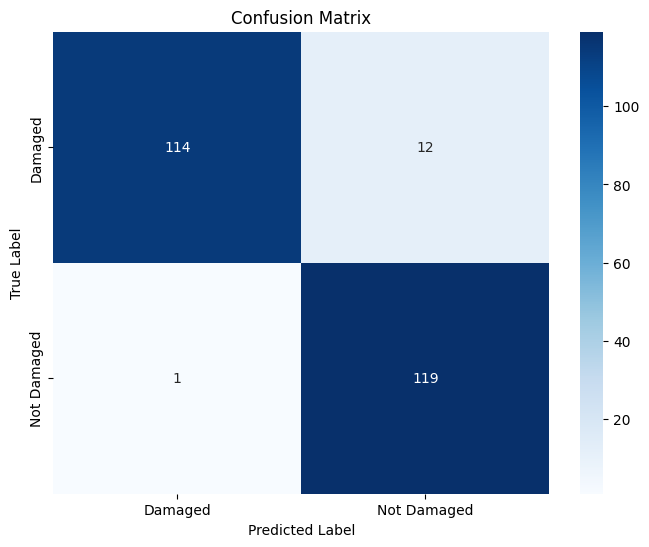


Model.evaluate() accuracy: 0.9472
Our calculation accuracy:  0.9472
✅ Evaluation completed successfully!


In [14]:
# EVALUATION - CLASSIFICATION REPORT AND CONFUSION MATRIX

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("MODEL EVALUATION")

# Reset generator and collect all predictions
validation_generator.reset()

all_predictions = []
all_true_labels = []

print("Collecting predictions...")

# Get predictions for all validation data
for i in range(len(validation_generator)):
    batch_images, batch_labels = next(validation_generator)
    batch_predictions = model.predict(batch_images, verbose=0)

    all_predictions.extend(batch_predictions.flatten())
    all_true_labels.extend(batch_labels)

# Convert to arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Convert probabilities to class predictions
predicted_classes = (all_predictions > 0.5).astype(int)

print("Data collected:")
print("Total samples:", len(all_true_labels))
print("Class distribution - Negative:", np.sum(all_true_labels == 0),
      "Positive:", np.sum(all_true_labels == 1))

# Classification Report
print("\nCLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(all_true_labels, predicted_classes,
                          target_names=['Damaged', 'Not Damaged'],
                          digits=4))

# Confusion Matrix
print("\nCONFUSION MATRIX")
print("=" * 50)

cm = confusion_matrix(all_true_labels, predicted_classes)
print("Actual \\ Predicted   Damaged   Not Damaged")
print("Damaged            {:^10} {:^12}".format(cm[0,0], cm[0,1]))
print("Not Damaged        {:^10} {:^12}".format(cm[1,0], cm[1,1]))

# Calculate overall accuracy
accuracy = np.mean(predicted_classes == all_true_labels)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Damaged', 'Not Damaged'],
            yticklabels=['Damaged', 'Not Damaged'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [15]:
# SAVE MODEL TO GOOGLE DRIVE

import os
from google.colab import drive

print("SAVING MODEL TO GOOGLE DRIVE")

# Mount Google Drive
drive.mount('/content/drive')

# Create folder if needed
drive_path = '/content/drive/MyDrive/DL_Egg_Project/'
os.makedirs(drive_path, exist_ok=True)

# Save model with accuracy in filename
model_filename = f'egg_classifier_94.6acc.keras'
full_path = drive_path + model_filename

try:
    model.save(full_path)

    # Check if file was saved
    if os.path.exists(full_path):
        file_size = os.path.getsize(full_path) / (1024*1024)
        print("Model saved successfully!")
        print("Location:", full_path)
        print("File size:", round(file_size, 1), "MB")
        print("Accuracy: 94.6%")
    else:
        print("Error: File not created")

except Exception as e:
    print("Error saving model:", e)

# Show all model files
print("\nModel files in folder:")
all_files = os.listdir(drive_path)
model_files = [f for f in all_files if f.endswith(('.keras', '.h5'))]

for file in model_files:
    file_path = drive_path + file
    file_size = os.path.getsize(file_path) / (1024*1024)
    print("-", file, "(", round(file_size, 1), "MB)")

print("Save completed!")

SAVING MODEL TO GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully!
Location: /content/drive/MyDrive/DL_Egg_Project/egg_classifier_94.6acc.keras
File size: 22.7 MB
Accuracy: 94.6%

Model files in folder:
- best_egg_model_fine_tuned.keras ( 25.3 MB)
- egg_classifier_mobilenetv2_93.5acc.keras ( 9.8 MB)
- egg_classifier_94.6acc.keras ( 22.7 MB)
Save completed!


Ready to test your model!
Upload an image of an egg
Upload an egg image to test...


Saving egg4.jpg to egg4.jpg
Uploaded: egg4.jpg


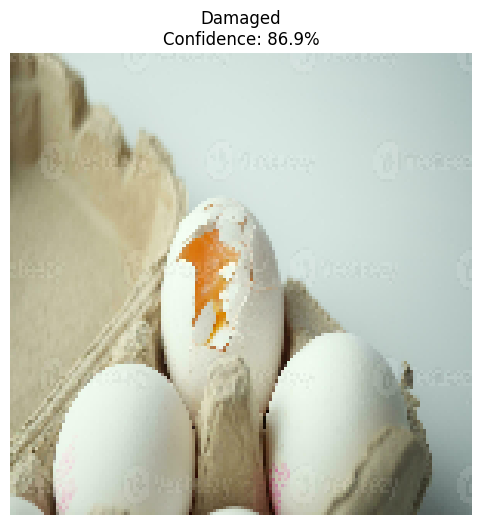

PREDICTION RESULT:
Image: egg4.jpg
Prediction: Damaged
Confidence: 0.869
Raw score: 0.1312
Test completed!
Prediction: Damaged with 0.869 confidence


In [17]:
# UPLOAD AND TEST YOUR OWN IMAGE

from google.colab import files
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def upload_and_test():
    print("Upload an egg image to test...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return

    # Get uploaded file
    image_name = list(uploaded.keys())[0]
    print("Uploaded:", image_name)

    try:
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(image_name, target_size=(150, 150))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        confidence = prediction[0][0]

        # Interpret prediction
        if confidence > 0.5:
            result = "Not Damaged"
            display_confidence = confidence
        else:
            result = "Damaged"
            display_confidence = 1 - confidence

        # Show result
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'{result}\nConfidence: {display_confidence:.1%}')
        plt.axis('off')
        plt.show()

        print("PREDICTION RESULT:")
        print("Image:", image_name)
        print("Prediction:", result)
        print("Confidence:", round(display_confidence, 3))
        print("Raw score:", round(confidence, 4))

        # Clean up
        if os.path.exists(image_name):
            os.remove(image_name)

        return result, display_confidence

    except Exception as e:
        print("Error:", e)
        # Clean up on error
        if os.path.exists(image_name):
            os.remove(image_name)
        return None, None

# Run the test
print("Ready to test your model!")
print("Upload an image of an egg")
result, confidence = upload_and_test()

if result:
    print("Test completed!")
    print("Prediction:", result, "with", round(confidence, 3), "confidence")
else:
    print("Test failed - try again")

In [18]:
!apt-get install git -y
!git config --global user.email "hwitn1610@gmail.com"
!git config --global user.name "TrinhNhatHuy"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
# Clone your forked repository
repo_url = "https://github.com/TrinhNhatHuy/Deep-learning---egg-detection.git"
!git clone {repo_url}

# Navigate to the folder
import os
os.chdir("egg-classification")